In [1]:
# import pandas as pd
# import numpy as np
# import re
#Importing everything from NLP Week 1 - following that as a guide for now
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.options.display.max_rows = 100
pd.options.display.width = 150
RANDOM_SEED = 696


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
pd.get_option("display.width")

150

In [3]:
WikiLarge_Train_df = pd.read_csv(r'assets/WikiLarge_Train.csv')#, \

In [4]:
# print(WikiLarge_Train_df.tail())
# print(WikiLarge_Train_df['label'].value_counts())

In [5]:
WikiLarge_Train_df['parsed_list'] = 0
WikiLarge_Train_df['All_Characters'] = 0
WikiLarge_Train_df['Is_Int'] = 0
for i, row in WikiLarge_Train_df.iterrows():
        temp = row['original_text']
        WikiLarge_Train_df['parsed_list'].at[i] = re.split(r'(\s)', temp)
        if temp.isalpha():
                WikiLarge_Train_df['All_Characters'].at[i] = 1
        try:
                int(temp)
                WikiLarge_Train_df['Is_Int'].at[i] = 1
        except:
                pass

        #WikiLarge_Train_df['parsed_list'].at[i] = re.split(r'(-|,|\s)\s*', temp)
        # Do we need to be greedy?

# Are commas always split by spaces?

In [6]:
print(WikiLarge_Train_df.head(5))

                                       original_text  label                                        parsed_list  All_Characters  Is_Int
0  There is manuscript evidence that Austen conti...      1  [There,  , is,  , manuscript,  , evidence,  , ...               0       0
1  In a remarkable comparative analysis , Mandaea...      1  [In,  , a,  , remarkable,  , comparative,  , a...               0       0
2  Before Persephone was released to Hermes , who...      1  [Before,  , Persephone,  , was,  , released,  ...               0       0
3  Cogeneration plants are commonly found in dist...      1  [Cogeneration,  , plants,  , are,  , commonly,...               0       0
4  Geneva -LRB- , ; , ; , ; ; -RRB- is the second...      1  [Geneva,  , -LRB-,  , ,,  , ;,  , ,,  , ;,  , ...               0       0


In [7]:
WikiLarge_Train_df['All_Characters'].value_counts()

0    407992
1      8776
Name: All_Characters, dtype: int64

In [8]:
#Not many -so I'm not going to worry about these
print(WikiLarge_Train_df['Is_Int'].value_counts())
print(WikiLarge_Train_df[WikiLarge_Train_df['Is_Int'] ==1 ]['label'].value_counts())
# The following shows there's no rhyme or reason to the way they're flagged
# WikiLarge_Train_df[WikiLarge_Train_df['Is_Int'] ==1 ].head(50)

0    416718
1        50
Name: Is_Int, dtype: int64
0    40
1    10
Name: label, dtype: int64


Okay, lets divide the set into train dev and test just for fun and see about getting started

In [9]:
train_df, dev_df, test_df = np.split(WikiLarge_Train_df.sample(frac=1, random_state= RANDOM_SEED), 
                       [int(.8*len(WikiLarge_Train_df)), int(.9*len(WikiLarge_Train_df))], axis = 0)

In [10]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(333414, 5)
(41677, 5)
(41677, 5)


FROM NLP Week 1:

What tokens should count as a "word" and how do we find them? For this exercise, we'll try extract three kinds of tokens using different methods to see what happens

1. ws_tokens: dict count of tokens separated by whitespace
2. alpha_ws_tokens: dict count of tokens separated by whitespace and are alpha numeric
3. alpha_re_tokens: dict count of tokens separated by word boundaries that only consist of alphanumeric characters

As quick example of how these are different, let's say we have the sentence "My computer says 'I don't know...' but after thinking about it, I think it does."

* The first case should return ['My', 'computer', 'says', "'I", "don't", "know...'", 'but', 'after', 'thinking', 'about', 'it,', 'I', 'think', 'it', 'does.'], which we can see contains a bunch of tokens that have punctuation with them.

* The second case should return ['My', 'computer', 'says', 'but', 'after', 'thinking', 'about', 'I', 'think', 'it'] which is filtering out a lot more tokens. We see that any token with any punctuation gets removed. This is probably too much but the tokens do look cleaner

* The third case should return ['My', 'computer', 'says', 'I', 'don', 't', 'know', 'but', 'after', 'thinking', 'about', 'it', 'I', 'think', 'it', 'does'], which gives us all the tokens. Here we see that it's also split "don't" into two tokens too! We could modify our regex some to allow intra-token punctuation to avoid this but for now we'll keep it a it simple.

In [11]:
ws_tokens = Counter()
alpha_ws_tokens = Counter()
alpha_re_tokens = Counter()
count = 0

for sent in tqdm(train_df.original_text):
#if count > 1:
    alphanumeric_list = []
    alpha_re_list = []
    sentlist = sent.split()

    ws_tokens.update(sentlist)

    for element in sentlist:
        #alphanumeric_regex = re.compile(r'[a-zA-Z0-9]+')
        alphanumeric_regex = re.compile(r'\w+')
        if re.fullmatch(alphanumeric_regex, element) != None:
            alphanumeric_list.append(element)
            #print("element:", element, "\nalpha_ws_list:",alpha_ws_list)

    alpha_re_list = re.findall(alphanumeric_regex, sent)
    alpha_ws_tokens.update(alphanumeric_list)
    alpha_re_tokens.update(alpha_re_list)

100%|████████████████████████████████████████████████████████████████████████| 333414/333414 [00:12<00:00, 25952.91it/s]


In [12]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

180497
150320
155812


In [13]:
top_50 = alpha_re_tokens.most_common(50)
#hidden tests are within this cell
top_50

[('the', 388051),
 ('of', 231298),
 ('in', 184434),
 ('and', 168008),
 ('a', 146692),
 ('is', 130853),
 ('to', 99037),
 ('RRB', 87115),
 ('LRB', 86878),
 ('The', 69017),
 ('was', 65924),
 ('as', 47474),
 ('for', 42317),
 ('by', 42126),
 ('on', 40038),
 ('with', 33040),
 ('s', 30582),
 ('that', 29589),
 ('from', 29501),
 ('are', 27668),
 ('an', 27376),
 ('or', 26066),
 ('It', 23917),
 ('at', 22762),
 ('his', 19793),
 ('which', 18768),
 ('In', 18721),
 ('it', 17895),
 ('also', 16284),
 ('has', 15611),
 ('be', 15144),
 ('he', 14975),
 ('born', 14891),
 ('first', 14506),
 ('were', 13468),
 ('France', 13454),
 ('He', 13349),
 ('one', 12754),
 ('known', 11524),
 ('who', 11262),
 ('United', 11159),
 ('not', 10888),
 ('its', 10738),
 ('department', 10574),
 ('have', 10282),
 ('city', 10253),
 ('A', 10196),
 ('de', 10067),
 ('1', 9896),
 ('commune', 9647)]

155812 0 155811
155812 0.05914372062349407 1.5241223608106686e-07


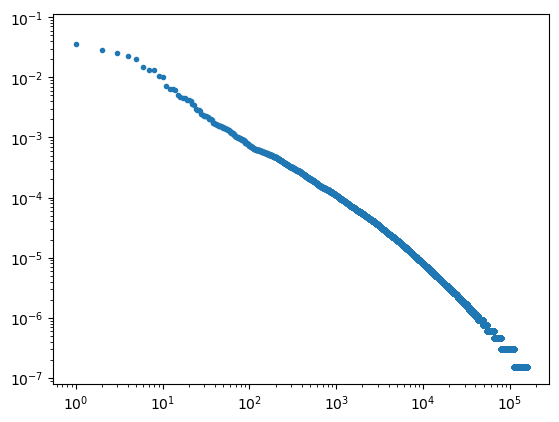

In [14]:
#Plot the word distribution
dict_pairs = dict(alpha_re_tokens)
total_counts = sum(dict_pairs.values())

#sorted_dict = {}
sorted_keys = sorted(dict_pairs, key=dict_pairs.get, reverse=True) 
x = [] #rank
y = [] #probability
count = 0
for w in sorted_keys:
    #print(w, dict_pairs[w], sorted_dict)
    x.append(count)
    y.append(dict_pairs[w] / total_counts)
    count += 1

print(len(x), x[0], x[-1])
print(len(y), y[0], y[-1])

ax = plt.plot(x, y, '.')
plt.yscale('log')
plt.xscale('log')

Convert text to features

In [15]:
vectorizer = TfidfVectorizer(min_df=500, stop_words= 'english')
X_train = vectorizer.fit_transform(train_df.original_text)
print(X_train.shape)

(333414, 1099)


In [16]:
#Make list of labels
y_train = list(train_df.label)

Fit the classifier - using all the data but could narrow this down to save time. Lets just see if it takes a long time

In [17]:
clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=500, multi_class='ovr', solver= 'newton-cholesky')
#clf.fit(X_train[0:10000,:], y_train[0:10000])
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=696,
                   solver='newton-cholesky')

Generate the dev data

In [18]:
X_dev = vectorizer.transform(dev_df.original_text)
y_dev = list(dev_df.label)
type(X_dev)

scipy.sparse._csr.csr_matrix

Create the Dummy Classifiers

In [19]:
uniform_dummy = DummyClassifier(strategy='uniform', random_state = RANDOM_SEED, constant=None)
most_freq_dummy = DummyClassifier(strategy='most_frequent', random_state = RANDOM_SEED, constant=None)

uniform_dummy.fit(X_train, y_train)
most_freq_dummy.fit(X_train, y_train)

DummyClassifier(random_state=696, strategy='most_frequent')

Generate the predictions

In [20]:
lr_tiny_dev_preds = clf.predict(X_dev)
rand_dev_preds = uniform_dummy.predict(X_dev)
mf_dev_preds = most_freq_dummy.predict(X_dev)

Score the predictions

In [21]:
lr_f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')
rand_f1 = f1_score(y_dev, rand_dev_preds, average='macro')
mf_f1 = f1_score(y_dev, mf_dev_preds, average='macro')
print(lr_f1)
print(rand_f1)
print(mf_f1)

0.6421682653633889
0.49840355363816646
0.333061289806369


Create a function for the steps so we can run it for various amounts of data to see the difference

## Matt experiments:

### 1
 TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii' ,stop_words='english', analyzer='char_wb', ngram_range=(1,3))
 
 LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=.1, multi_class='ovr', solver= 'newton-cg')
 
 [0.5367548454017107, 0.655777640516025, 0.674599129866489, 0.6804460573909678, 0.688381517756455]

### 2
 TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii' ,stop_words='english', analyzer='char_wb', ngram_range=(1,3), lowercase=False)
 
  LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=.1, multi_class='ovr', solver= 'newton-cg')
 
 [0.5431826182998672, 0.6592851964393285, 0.6770780203143197, 0.682915289861274, 0.6933228754367546]

In [27]:
# Vectorizer
vectorizer = TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii',  analyzer='char_wb', ngram_range=(1,3), lowercase=False)

# Transform data and labels
X_train = vectorizer.fit_transform(train_df.original_text)
y_train = list(train_df.label)

# Pipeline and grid
pipeline = Pipeline([('classifier', LogisticRegression())])

param_grid = [
    {'classifier': [LogisticRegression()],WW
     'classifier__penalty' : ['l2'],
     'classifier__C': np.logspace(0,4,50),
     'classifier__solver': ['newton-cholesky', 'newton-cg'],
    }
]

# Grid setup and train
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=4, pre_dispatch=4)

best_clf = clf.fit(X_train, y_train)

/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/matt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: Convergenc

In [32]:
best_clf.best_params_

{'classifier': LogisticRegression(solver='newton-cholesky'),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cholesky'}

In [34]:
def train_and_score(train_df, dev_df):
    # Fit a new TfidfVectorizer
    #vectorizer = TfidfVectorizer(min_df=25, stop_words= 'english')
    vectorizer = TfidfVectorizer(min_df=25, max_df= .9, strip_accents='ascii',  analyzer='char_wb', ngram_range=(1,3), lowercase=False)
    X_train = vectorizer.fit_transform(train_df.original_text)

    #Get the labels
    y_train = list(train_df.label)

    #Fit the data to a Logistic Regression Classifier (in this example a subset of 10k)
    #clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='auto', solver= 'lbfgs')
    clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=500, C=1, multi_class='ovr', solver= 'newton-cholesky')
    clf.fit(X_train, y_train)

    # Generate the dev data
    X_dev = vectorizer.transform(dev_df.original_text)
    y_dev = list(dev_df.label)

    # Generate the predictions
    lr_tiny_dev_preds = clf.predict(X_dev)

    # Score the predictions
    f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')

    # the function returns the macro-averaged F1 score on the dev data
    return f1

def change_in_performance(training_sizes, train_df, dev_df):
    random.seed(RANDOM_SEED)
    f1_scores = []
    for training_size in tqdm(training_sizes):
        f1_scores.append(train_and_score(train_df.head(training_size), dev_df))
    return(f1_scores)

training_sizes = [1000, 10000, 50000, 100000, 333414]
performace_f1_scores = change_in_performance(training_sizes, train_df, dev_df)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:32<00:00, 66.54s/it]


Used these tips from NLP Week 1 to fine tune:

Overall lots of room for improvement. We could certainly try fine-tuning some of the hyperparameters though! Some useful ideas to try by altering the TF-IDF vectorizer or classifier:
* use lower `min_df` to increase the number of features
* don't use stopword removal
* tune the `C` parameter on the logistic regression classifier
* don't lower-case the text 
* use a `CountVectorizer` instead of a TF-IDF vectorizer
* set `max_df` to remove common features

Which do you think will lead to higher performance? Try some out and report on the Slack or Piazza what's the highest performance you can achieve!

[0.6183723953111302, 0.6673916826003882, 0.6818282649034958, 0.6877756360255619, 0.6962710421128029]


<AxesSubplot: xlabel='num_instances', ylabel='f1'>

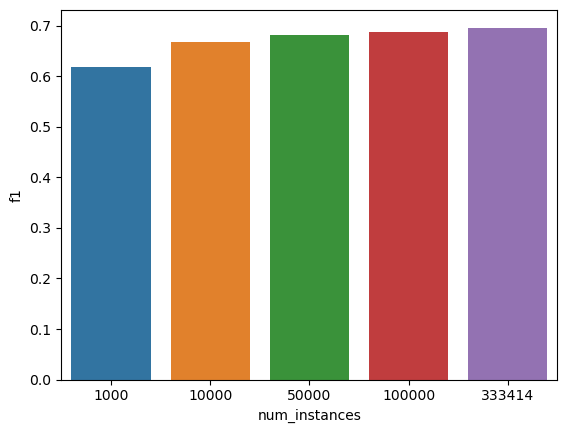

In [35]:
print(performace_f1_scores)

df = pd.DataFrame({'num_instances': training_sizes, 'f1': performace_f1_scores})
sns.barplot(data=df, x='num_instances', y='f1')

Try a uni, bi, and trigram vectorizer

In [27]:
trigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=25, ngram_range=(1,3))
X_train = trigram_vectorizer.fit_transform(train_df.original_text)
print(X_train.shape)
clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr', solver= 'newton-cg')
clf.fit(X_train, y_train)
#featurize the dev data
X_dev = trigram_vectorizer.transform(dev_df.original_text)
#predict the dev data and score
lr_trigram_dev_preds = clf.predict(X_dev)
lr_f1 = f1_score(y_dev, lr_trigram_dev_preds, average='macro')

(333414, 23797)


In [28]:
print(lr_f1)

0.6879448653584948


min_df @ 500, ngram_range(1,3), multi_class='ovr', solver = 'newton-cholesky' (didn't take too long) scored 0.6451618658
min_df @  25, ngram_range(1,3), multi_class='ovr', solver = 'newton-cholesky' (6m 19.1s) scored 0.6880169450552442

Read in the Dale Chall text - into a list

In [30]:
dc_text = open(r'assets/dale_chall.txt', "r")
dalechall_file = dc_text.read()
# split text on new line
dalechall_list = dalechall_file.split('\n')
print(dalechall_list[0:5])

['a', 'able', 'aboard', 'about', 'above ']


In [31]:
len(dalechall_list)

2950

# Scores

In [57]:
# !pip install spacy
# !pip install spacy_syllables
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm

In [54]:
import re
import spacy
from spacy_syllables import SpacySyllables

In [58]:
# using https://spacy.io/universe/project/spacy_syllables
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("syllables", after="tagger")

In [60]:
split_pat = re.compile(r'\b\s+\b')

WikiLarge_Train_df['og_split'] = WikiLarge_Train_df['original_text'].apply(lambda x: re.split(split_pat, x))
WikiLarge_Train_df['total_words'] = WikiLarge_Train_df['og_split'].apply(lambda x: len(x))
WikiLarge_Train_df['long_words'] = WikiLarge_Train_df['og_split'].apply(lambda x: len([y for y in x if len(y) > 7]))
WikiLarge_Train_df['total_sentences'] = 1
WikiLarge_Train_df['total_characters'] = WikiLarge_Train_df['og_split'].apply(lambda x: sum([len(y) for y in x]))
WikiLarge_Train_df['syl_list'] = WikiLarge_Train_df['original_text'].apply(lambda x: [token._.syllables_count for token in nlp(x)])

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [62]:
WikiLarge_Train_df

,original_text,label,parsed_list,All_Characters,Is_Int,total_words,og_split,long_words,total_sentences,total_characters,syl_list
0,There is manuscript evidence that Austen conti...,1,"[There, , is, , manuscript, , evidence, , ...",0,0,34,"[There, is, manuscript, evidence, that, Austen...",7,1,182,"[1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"In a remarkable comparative analysis , Mandaea...",1,"[In, , a, , remarkable, , comparative, , a...",0,0,19,"[In, a, remarkable, comparative, analysis , Ma...",6,1,136,"[1, 1, 3, 4, 3, None, 2, 2, 1, None, 2, 3, 1, ..."
2,"Before Persephone was released to Hermes , who...",1,"[Before, , Persephone, , was, , released, ...",0,0,36,"[Before, Persephone, was, released, to, Hermes...",10,1,213,"[2, 2, 1, 2, 1, 2, None, 1, 1, 1, 1, 1, 2, 1, ..."
3,Cogeneration plants are commonly found in dist...,1,"[Cogeneration, , plants, , are, , commonly,...",0,0,26,"[Cogeneration, plants, are, commonly, found, i...",11,1,221,"[5, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, None, 3, Non..."
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[Geneva, , -LRB-, , ,, , ;, , ,, , ;, , ...",0,0,18,"[Geneva -LRB- , ; , ; , ; ; -RRB- is, the, sec...",8,1,184,"[2, None, None, None, None, None, None, None, ..."
...,...,...,...,...,...,...,...,...,...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0,"[A, , Duke, , Nukem, , 3D, , version, , h...",0,0,14,"[A, Duke, Nukem, 3D, version, has, been, sold,...",2,1,66,"[1, 1, 1, None, 2, 1, 1, 1, 1, 1, 1, 1, 3, Non..."
416764,"However , it is becoming replaced as a method ...",0,"[However, , ,, , it, , is, , becoming, , ...",0,0,17,"[However , it, is, becoming, replaced, as, a, ...",6,1,95,"[3, None, 1, 1, 3, 2, 1, 1, 1, 1, 4, 3, 1, 1, ..."
416765,There are hand gestures in both Hindu and Budd...,0,"[There, , are, , hand, , gestures, , in, ...",0,0,10,"[There, are, hand, gestures, in, both, Hindu, ...",3,1,55,"[1, 1, 1, 2, 1, 1, 2, 1, 2, 3, None]"
416766,"If it is necessary to use colors , try to choo...",0,"[If, , it, , is, , necessary, , to, , use...",0,0,34,"[If, it, is, necessary, to, use, colors , try,...",7,1,183,"[1, 1, 1, 3, 1, 1, 2, None, 1, 1, 1, 2, 1, 1, ..."


In [63]:
WikiLarge_Train_df['syl_list'] = WikiLarge_Train_df['syl_list'].apply(lambda x: [y for y in x if y is not None])
WikiLarge_Train_df['total_syllables'] = WikiLarge_Train_df['syl_list'].apply(lambda x: sum(x))
WikiLarge_Train_df['total_polysyllables'] = WikiLarge_Train_df['syl_list'].apply(lambda x: sum([1 for y in x if y>2]))


WikiLarge_Train_df

,original_text,label,parsed_list,All_Characters,Is_Int,total_words,og_split,long_words,total_sentences,total_characters,syl_list,total_syllables,total_polysyllables
0,There is manuscript evidence that Austen conti...,1,"[There, , is, , manuscript, , evidence, , ...",0,0,34,"[There, is, manuscript, evidence, that, Austen...",7,1,182,"[1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...",48,5
1,"In a remarkable comparative analysis , Mandaea...",1,"[In, , a, , remarkable, , comparative, , a...",0,0,19,"[In, a, remarkable, comparative, analysis , Ma...",6,1,136,"[1, 1, 3, 4, 3, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, ...",37,5
2,"Before Persephone was released to Hermes , who...",1,"[Before, , Persephone, , was, , released, ...",0,0,36,"[Before, Persephone, was, released, to, Hermes...",10,1,213,"[2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...",56,4
3,Cogeneration plants are commonly found in dist...,1,"[Cogeneration, , plants, , are, , commonly,...",0,0,26,"[Cogeneration, plants, are, commonly, found, i...",11,1,221,"[5, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 3, 2, 1, 3, ...",57,6
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[Geneva, , -LRB-, , ,, , ;, , ,, , ;, , ...",0,0,18,"[Geneva -LRB- , ; , ; , ; ; -RRB- is, the, sec...",8,1,184,"[2, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, ...",36,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0,"[A, , Duke, , Nukem, , 3D, , version, , h...",0,0,14,"[A, Duke, Nukem, 3D, version, has, been, sold,...",2,1,66,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3]",15,1
416764,"However , it is becoming replaced as a method ...",0,"[However, , ,, , it, , is, , becoming, , ...",0,0,17,"[However , it, is, becoming, replaced, as, a, ...",6,1,95,"[3, 1, 1, 3, 2, 1, 1, 1, 1, 4, 3, 1, 1, 2, 1, ...",31,5
416765,There are hand gestures in both Hindu and Budd...,0,"[There, , are, , hand, , gestures, , in, ...",0,0,10,"[There, are, hand, gestures, in, both, Hindu, ...",3,1,55,"[1, 1, 1, 2, 1, 1, 2, 1, 2, 3]",15,1
416766,"If it is necessary to use colors , try to choo...",0,"[If, , it, , is, , necessary, , to, , use...",0,0,34,"[If, it, is, necessary, to, use, colors , try,...",7,1,183,"[1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, ...",53,3


In [87]:
WikiLarge_Train_df['total_unique_words'] = WikiLarge_Train_df['og_split'].apply(lambda x: len(set(x)))

In [91]:
base_calculated = ['total_words', 'long_words', 'total_sentences', 'total_characters', 'syl_list', 'total_syllables', 'total_polysyllables', 'total_unique_words']

In [92]:
WikiLarge_Train_df[base_calculated].to_csv('assets/base_calculations.csv')

In [72]:
WikiLarge_Train_df['og_split'].to_csv('assets/bsb_token_split.csv')

In [75]:
# !ls -lha assets

In [78]:
# esitmates the years of formal education a person needs to understand the tet on first reading.
WikiLarge_Train_df['gfi'] = 0.4 * (WikiLarge_Train_df['total_words'] + 100 * WikiLarge_Train_df['long_words'])
WikiLarge_Train_df['gfi']

0         293.6
1         247.6
2         414.4
3         450.4
4         327.2
          ...  
416763     85.6
416764    246.8
416765    124.0
416766    293.6
416767     40.8
Name: gfi, Length: 416768, dtype: float64

In [80]:
# FRE ( Flesch reading ease) assigns higher values to more readable texts.
WikiLarge_Train_df['fre'] = 206.835 - 1.015*(WikiLarge_Train_df['total_words']) - 84.6 * (WikiLarge_Train_df['total_syllables']/WikiLarge_Train_df['total_words'])
WikiLarge_Train_df['fre']

0          52.889706
1          22.802632
2          38.695000
3          -5.024231
4          19.365000
             ...    
416763    101.982143
416764     35.309412
416765     69.785000
416766     40.448529
416767     -6.695000
Name: fre, Length: 416768, dtype: float64

In [81]:
# (FKGL) Flesch-Kincaid grade level is the number of years of education generally required to understand the text for which the formula was calculated
WikiLarge_Train_df['fkgl'] = 0.39 * (WikiLarge_Train_df['total_words']) + 11.8 * (WikiLarge_Train_df['total_syllables']/WikiLarge_Train_df['total_words']) - 15.59
WikiLarge_Train_df['fkgl']

0         14.328824
1         14.798947
2         16.805556
3         20.419231
4         15.030000
            ...    
416763     2.512857
416764    12.557647
416765     6.010000
416766    16.064118
416767    14.690000
Name: fkgl, Length: 416768, dtype: float64

In [84]:
# ARI (Automated readability index) years of education required to understand the text
WikiLarge_Train_df['ari'] = 4.71 * (WikiLarge_Train_df['total_characters'] / WikiLarge_Train_df['total_words']) + 0.5 * (WikiLarge_Train_df['total_words']) - 21.43
WikiLarge_Train_df['ari']

0         20.782353
1         21.783684
2         24.437500
3         31.605000
4         35.716667
            ...    
416763     7.774286
416764    13.390588
416765     9.475000
416766    20.920882
416767    24.315000
Name: ari, Length: 416768, dtype: float64

In [85]:
# SMOG (simple measurement of Gobbledygook) roughly corresponds to the number of years of education needed to understand the text
WikiLarge_Train_df['smog'] = 1.0430 * np.sqrt(WikiLarge_Train_df['total_polysyllables'] * 30) + 3.1291
WikiLarge_Train_df['smog']

0         15.903189
1         15.903189
2         14.554593
3         17.122413
4         11.208143
            ...    
416763     8.841846
416764    15.903189
416765     8.841846
416766    13.023867
416767     8.841846
Name: smog, Length: 416768, dtype: float64

In [93]:
# TTR (Type Token Ratio) (number of unique words / number of words)
WikiLarge_Train_df['ttr'] = WikiLarge_Train_df['total_unique_words'] / WikiLarge_Train_df['total_words']
WikiLarge_Train_df['ttr']

# RTTR (root type token ratio)
WikiLarge_Train_df['ttr'] = WikiLarge_Train_df['total_unique_words'] / np.sqrt(WikiLarge_Train_df['total_words'])

# CTTR (corrected type token ratio)
WikiLarge_Train_df['ttr'] = WikiLarge_Train_df['total_unique_words'] / np.sqrt(2 * WikiLarge_Train_df['total_words'])

0         0.823529
1         1.000000
2         0.833333
3         0.923077
4         0.833333
            ...   
416763    1.000000
416764    1.000000
416765    1.000000
416766    0.852941
416767    1.000000
Name: ttr, Length: 416768, dtype: float64

In [ ]:
# MSTTR is the average TTR for each non-overlapping segment of equal size
segment_size = 5

def msttr_helper(lst:list, segment_size:int=segment_size):
    segment_size = np.min(segment_size, len(lst))
    lst = [x.lower() for x in lst]
    segments = [lst[i*segment_size: i*segment_size + segment_size] for i in range(int(np.ceil(len(lst)/segment_size)))]
    segment_ttr_vals = [len(set(x)) / segment_size for x in segments if len(x) == segment_size]
    
    return np.sum(segment_ttr_vals)/len(segment_ttr_vals)

    
# WikiLarge_Train_df['msttr'] = WikiLarge_Train_df['og_split'].apply(msttr_helper)
WikiLarge_Train_df['og_split'].apply(msttr_helper)

In [ ]:
# MATTR is the average TTR for all possible overlapping segments of equal size. 
segment_size = 5

def mattr_helper(lst:list, segment_size:int=segment_size):
    segment_size = np.min(segment_size, len(lst))
    lst = [x.lower() for x in lst]
    segments = [lst[i: i + segment_size] for i in range(len(lst))]
    segment_ttr_vals = [len(set(x)) / segment_size for x in segments if len(x) == segment_size]
    
    return np.sum(segment_ttr_vals)/len(segment_ttr_vals)

# WikiLarge_Train_df['mattr'] = WikiLarge_Train_df['og_split'].apply(msttr_helper)
WikiLarge_Train_df['og_split'].apply(mattr_helper)